# Bart-webinar, Exercise

## This is an exercise notebook to practice the bart ecalib and pics command. 

The general workflow of this notebook is as follows:- 
1. Import k-space data from the numpy file, there are 2 separate arrays for the undersampled k-space data and the reference scan which is fully sampled in the calibration region. 
2. Visualize the k-spsace data for both the files and see the fully sampled calibration region and the undersampled k-space data
3. Do a naive ifft to see what does that represent and how the aliasing is happening. 
4. Estimate the sensitivity maps from the reference scan
5. Use the sensitivity maps and the undersampled k-space data to reconstruct the image using the bart parrallel imaging command "pics"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bart import bart
import h5py
%matplotlib inline

In [2]:
with h5py.File('bart_webinar4_data.h5', 'r') as F:
    ksp_und = np.array(F['ksp_und'])
    ksp_ref = np.array(F['ksp_ref'])
    
print('ksp_und:', ksp_und.shape)
print('ksp_ref:', ksp_ref.shape)

ksp_und: (288, 288, 1, 12)
ksp_ref: (47, 288, 1, 12)


In [3]:
dim_ro = ksp_und.shape[0]
ksp_ref = bart(1,'resize -c 0 {}'.format(dim_ro), ksp_ref) # bring the reference scan to reqruied shape

print('ksp_und:', ksp_und.shape)
print('ksp_ref:', ksp_ref.shape)

ksp_und: (288, 288, 1, 12)
ksp_ref: (288, 288, 1, 12)


Only showing the first 6 coils


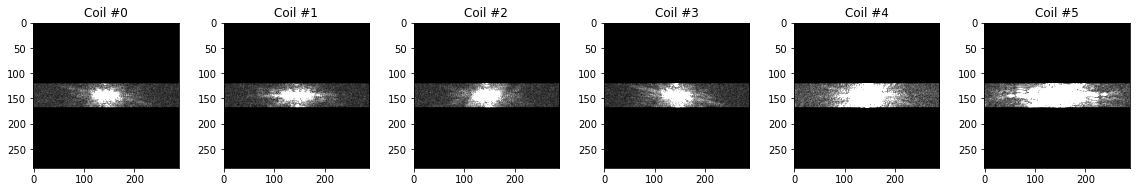

In [4]:
#visualize the ref scan kspace
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(ksp_ref[...,index]),cmap='gray',vmax=.00001)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

In [5]:
# do an ifft of the ref k-space data
cimg_ref = bart(1,'fft -i -u 3', ksp_ref)
print(cimg_ref.shape)

(288, 288, 1, 12)


Only showing the first 6 coils


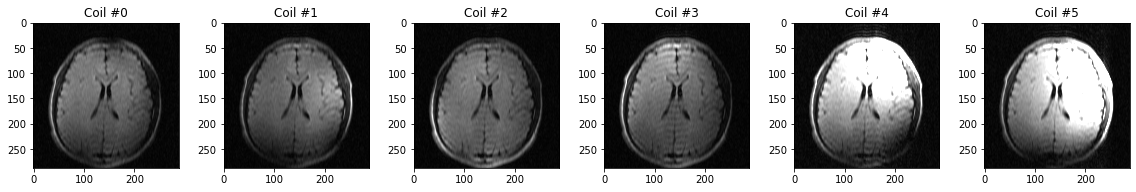

In [6]:
#visualize the calibration images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_ref[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Text(0.5, 1.0, 'Reference scan RSS')

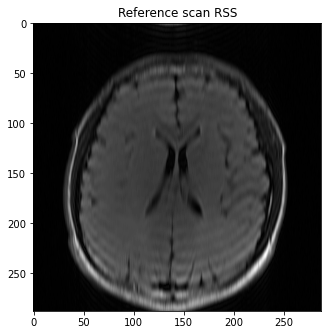

In [7]:
# visualize the RSS image
rss_ref = bart(1, 'rss 8', cimg_ref)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_ref),cmap='gray')
ax.set_title('Reference scan RSS')

In [8]:
# get the scale factor from the reference data
scale_factor = np.percentile(abs(rss_ref), 99)
print('Scale factor: {:.5f}'.format(scale_factor))

Scale factor: 0.00024


Only showing the first 6 coils


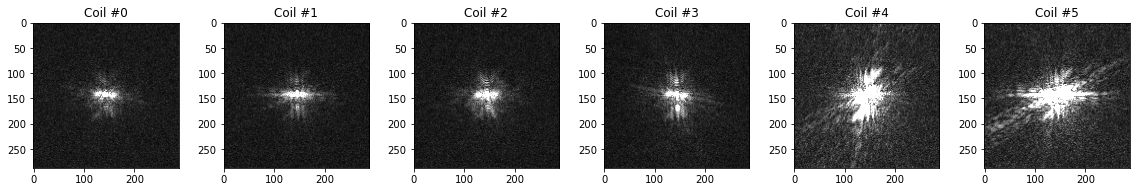

In [9]:
# undersampled k-space data of the main image
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(ksp_und[...,index]),cmap='gray',vmax=.00001)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Text(0.5, 1.0, 'Acceleration Factor: R=2.00')

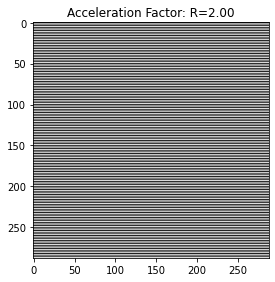

In [10]:
# calculate the sampling pattern
mask = bart(1, 'pattern', ksp_und).real
R = np.prod(np.shape(mask)) / np.sum(mask) # acceleration factor

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.tight_layout() # This automatically puts space between plots and make it tidy
axes.imshow(mask, cmap='gray')
plt.title('Acceleration Factor: R={:.2f}'.format(R))


In [11]:
#take a naive ifft
cimg_und = bart(1,'fft -i -u 3', ksp_und)
print(cimg_und.shape)

(288, 288, 1, 12)


Only showing the first 6 coils


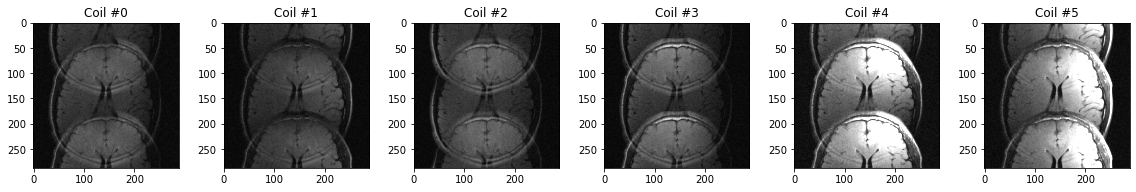

In [12]:
#visualize the aliased images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_und[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Text(0.5, 1.0, 'Under-sampled RSS')

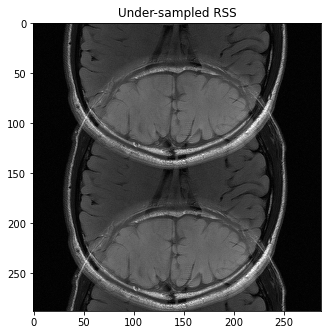

In [13]:
# visualize the RSS image
rss_und = bart(1, 'rss 8', cimg_und)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_und),cmap='gray')
ax.set_title('Under-sampled RSS')

In [14]:
# run coil compression to get coil compression matrix
cc_matrix = bart(1, 'bart cc -M', ksp_ref)
print(cc_matrix.shape)

(1, 1, 1, 12, 12)


In [15]:
# apply coil compression to 6 virtual coils -- apply to ref and to kspace data!
num_vcoils = 8
ksp_cc_ref = bart(1, 'ccapply -p {}'.format(num_vcoils), ksp_ref, cc_matrix)
ksp_cc_und = bart(1, 'ccapply -p {}'.format(num_vcoils), ksp_und, cc_matrix)
print(ksp_cc_ref.shape)
print(ksp_cc_und.shape)

(288, 288, 1, 8)
(288, 288, 1, 8)


In [16]:
#bart ecalib help
!bart ecalib -h

WARN: BART version is not reproducible.
Usage: ecalib [-t f] [-c f] [-k d:d:d] [-r d:d:d] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivities> [<ev-maps>] 

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold     This determined the size of the null-space.
-c crop_value    Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize         kernel size
-r cal_size      Limits the size of the calibration region.
-m maps          Number of maps to compute.
-S               create maps with smooth transitions (Soft-SENSE).
-W               soft-weighting of the singular vectors.
-I               intensity correction
-1               perform only first part of the calibration
-P               Do not rotate the phase with respect to the first principal component
-v variance      Variance of noise in data.
-a               Automatically pick thresholds.
-d level         Debug level
-h          

In [17]:
# estimate the coil sensitivities
coil_sens, ev_maps= bart(2, 'ecalib -a -m 1', ksp_cc_ref) # estimate coil sensitivities using the Auto-ESPIRiT algorithm
print(coil_sens.shape)

(288, 288, 1, 8)


coil sensitivity maps


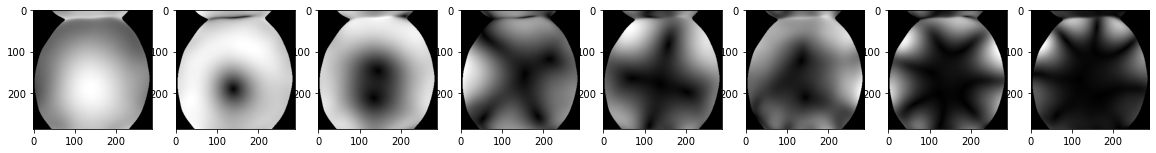

In [18]:
# visvualize the estimated coil sensitivities
plt.figure(figsize=(20,6))
for index in range(num_vcoils):
    plt.subplot(1,num_vcoils,index+1)
    plt.imshow(np.abs(coil_sens[..., index]),cmap='gray')
print('coil sensitivity maps')

In [19]:
#bart pics command help
#!bart pics -h

In [20]:
# reconstruct the image using bart parallel imaging command
l2_reg = 1e-4
reco_l2 = bart(1, 'pics -w {} -R Q:{} -S'.format(scale_factor, l2_reg), ksp_cc_und, coil_sens)
print(reco_l2.shape)

(288, 288)


Text(0.5, 1.0, 'T2 FLAIR reconstructed')

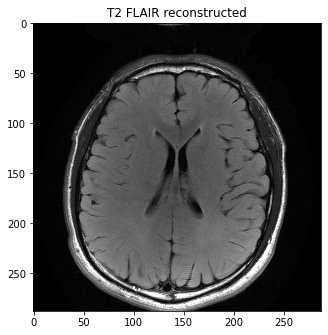

In [21]:
# visualize the reconstructed T2-FLAIR image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(reco_l2), cmap='gray', vmax=.0003)
ax.set_title('T2 FLAIR reconstructed')

## Undersampling by an additional factor of 2
In simulation undersampling can be performed in both the directions i.e. phase and frequency encode. However on actual scanner, the frequency encode direction is always fully sampled. 

In [22]:
ksp_cc_und_4x = np.zeros((ksp_cc_und.shape),dtype=complex)
ksp_cc_und_4x[1::4,...] = ksp_cc_und[1::4,...] #undersampling in the phase encode direction
# ksp_cc_und_4x[:,1::2,:] = ksp_cc_und[:,1::2,:] #undersampling in the frequency encode direction

In [23]:
#take a naive ifft
cimg_und_4x = bart(1,'fft -i -u 3', ksp_cc_und_4x)
print(cimg_und_4x.shape)

(288, 288, 1, 8)


Only showing the first 6 coils


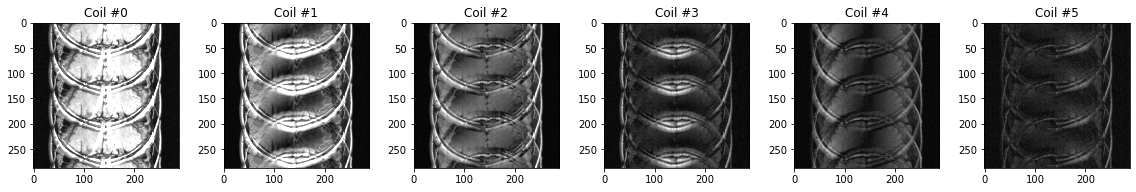

In [24]:
#visualize the aliased images
fig, axes = plt.subplots(1, 6, figsize=(16, 8))
plt.tight_layout() # This automatically puts space between plots and make it tidy

for ax, index in zip(axes, range(12)):
    ax.imshow(np.abs(cimg_und_4x[...,index]),cmap='gray',vmax=.00003)
    ax.set_title('Coil #{}'.format(index))
print('Only showing the first 6 coils')

Text(0.5, 1.0, 'Under-sampled RSS')

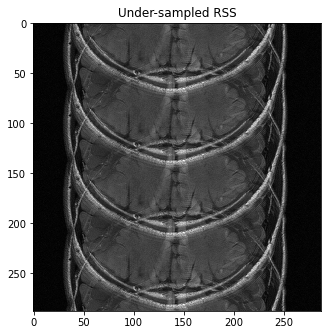

In [25]:
# visualize the RSS image
rss_und_4x = bart(1, 'rss 8', cimg_und_4x)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(rss_und_4x),cmap='gray')
ax.set_title('Under-sampled RSS')

Text(0.5, 1.0, 'Acceleration Factor: R=4.00')

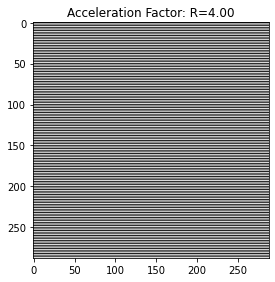

In [26]:
# calculate the sampling pattern
mask_4x = bart(1, 'pattern', ksp_cc_und_4x).real
R_4x = np.prod(np.shape(mask_4x)) / np.sum(mask_4x) # acceleration factor

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.tight_layout() # This automatically puts space between plots and make it tidy
ax.imshow(mask, cmap='gray')
plt.title('Acceleration Factor: R={:.2f}'.format(R_4x))

In [27]:
# reconstruct the image using bart parallel imaging command
l2_reg_4x = l2_reg
reco_l2_4x = bart(1,'pics -w {} -R Q:{}  -S'.format(scale_factor, l2_reg_4x), ksp_cc_und_4x, coil_sens)
print(reco_l2_4x.shape)

(288, 288)


Text(0.5, 1.0, 'T2 FLAIR 4X reconstructed')

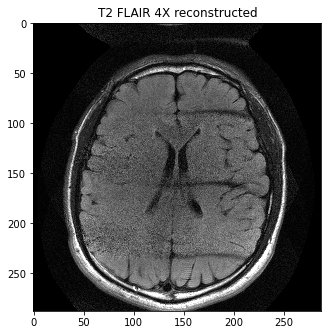

In [28]:
# visualize the reconstructed T2-FLAIR image
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.imshow(np.abs(reco_l2_4x), cmap='gray', vmax=.0003)
ax.set_title('T2 FLAIR 4X reconstructed')